# **Import libraries**

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os


# **Setup: Install and Download Required Files**

In [6]:
# Download the necessary files
!wget -q -nc https://pjreddie.com/media/files/yolov3.weights
!wget -q -nc https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget -q -nc https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

# Ensure the files are properly downloaded
assert os.path.exists("yolov3.weights"), "The file yolov3.weights is missing."
assert os.path.exists("yolov3.cfg"), "The file yolov3.cfg is missing."
assert os.path.exists("coco.names"), "The file coco.names is missing."

# **Load Class Names and YOLO model**

In [7]:
# Load class names from the coco.names file
with open('coco.names', 'r') as f:
    classes = f.read().strip().split('\n')

# Load the YOLOv3 model
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

# **Load and Preprocess the Image**

In [8]:
# Import an image
from google.colab import files
uploaded = files.upload()

# Ensure an image has been uploaded
image_path = next(iter(uploaded.keys()))
image = cv2.imread(image_path)
assert image is not None, "Error reading the image."

# Preprocess the image
height, width = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

# Get the output layer names for unconnected layers
output_layers = net.getUnconnectedOutLayersNames()
detections = net.forward(output_layers)

Saving autoroute.jpg to autoroute.jpg


# **Analyze and Filter Detections**

In [9]:
boxes, confidences, class_ids = [], [], []

for output in detections:
    for detection in output:
        # Extract the scores, class ID, and confidence level
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:  # Confidence threshold
            # Scale bounding box coordinates back to the original image size
            box = detection[0:4] * np.array([width, height, width, height])
            (centerX, centerY, w, h) = box.astype("int")
            x = int(centerX - (w / 2))
            y = int(centerY - (h / 2))
            boxes.append([x, y, int(w), int(h)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply non-max suppression to eliminate redundant overlapping boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# **Draw Bounding Boxes**

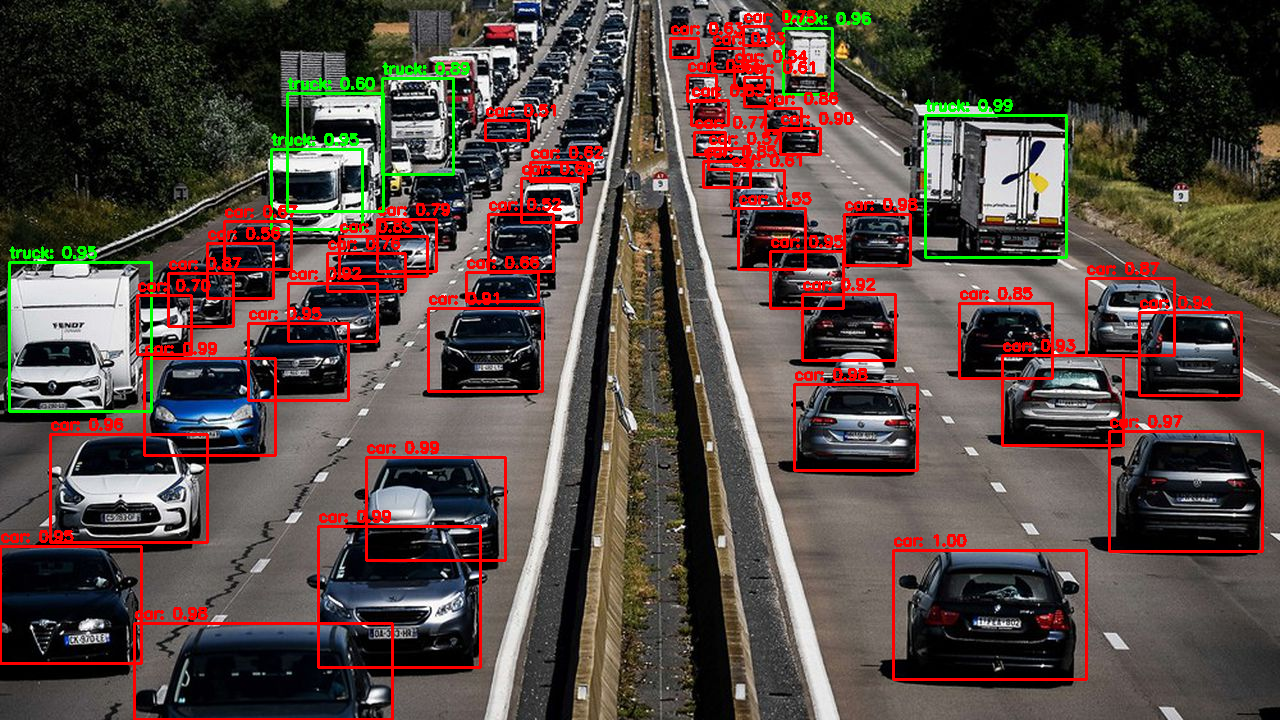

In [10]:
# Draw bounding boxes on the image
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        if classes[class_ids[i]] == "car":
            color = (0, 0, 255)  # Red for cars
        else:
            color = (0, 255, 0)  # Green for other objects
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the resulting image
cv2_imshow(image)